# Domain agnostic feature engineering using deep learning and Bayesian inference: Automating the automation
- Hamaad Shah
- Jeremy Achin

---

We will explore the use of autoencoders for automatic feature engineering. The idea is to automatically learn a set of features from raw data that can be useful in supervised learning tasks such as in computer vision and insurance.

## Computer Vision

---

We will use the MNIST dataset for this purpose where the raw data is a 2 dimensional tensor of pixel intensities per image. The image is our unit of analysis: We will predict the probability of each class for each image. This is a multiclass classification task and we will use the one against all AUROC score and accuracy score to assess model performance on the test fold.

## Insurance

---

We will use a synthetic dataset where the raw data is a 2 dimensional tensor of historical policy level information per policy-period combination: Per unit this will be $\mathbb{R}^{4\times3}$, i.e., 4 historical time periods and 3 transactions types. The policy-period combination is our unit of analysis: We will predict the probability of loss for time period 5 in the future - think of this as a potential renewal of the policy for which we need to predict whether it would make a loss for us or not hence affecting whether we decided to renew the policy and / or adjust the renewal premium to take into account the additional risk. This is a binary class classification task and we will use the AUROC score and accuracy score to assess model performance.

In [1]:
# Author: Hamaad Shah.
# Code repo: https://github.com/hamaadshah/autoencoders

import os
import math
import sys
import importlib

import numpy as np

import pandas as pd

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from scipy.stats import norm

import keras
from keras import backend as bkend
from keras.datasets import cifar10, mnist
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, convolutional, pooling
from keras import metrics

from autoencoders_keras.get_session import get_session
import keras.backend.tensorflow_backend as KTF
KTF.set_session(get_session(gpu_fraction=0.75, allow_soft_placement=True, log_device_placement=False))

import tensorflow as tf
from tensorflow.python.client import device_lib

from plotnine import *

import matplotlib.pyplot as plt

from autoencoders_keras.vanilla_autoencoder import VanillaAutoencoder
from autoencoders_keras.convolutional_autoencoder import ConvolutionalAutoencoder
from autoencoders_keras.convolutional2D_autoencoder import Convolutional2DAutoencoder
from autoencoders_keras.seq2seq_autoencoder import Seq2SeqAutoencoder
from autoencoders_keras.variational_autoencoder import VariationalAutoencoder

%matplotlib inline

np.set_printoptions(suppress=True)

os.environ["KERAS_BACKEND"] = "tensorflow"
importlib.reload(bkend)

print(device_lib.list_local_devices())

mnist = mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1] * X_train.shape[1]])
X_test = np.reshape(X_test, [X_test.shape[0], X_test.shape[1] * X_test.shape[1]])
y_train = y_train.ravel()
y_test = y_test.ravel()
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255.0
X_test /= 255.0

Using TensorFlow backend.
/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4600790436166592709
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 1810374656
locality {
  bus_id: 1
}
incarnation: 12140715285371242784
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:c2:00.0"
]


## Scikit-learn

---

We will use the Python machine learning library scikit-learn for data transformation and the classification task. Note that we will code the autoencoders as scikit-learn transformers such that they can be readily used by scikit-learn pipelines.

In [2]:
scaler_classifier = MinMaxScaler(feature_range=(0.0, 1.0))
logistic = linear_model.LogisticRegression(random_state=666)
lb = LabelBinarizer()
lb = lb.fit(y_train.reshape(y_train.shape[0], 1))

## MNIST: No Autoencoders

---

We run the MNIST dataset without using an autoencoder. The 2 dimensional tensor of pixel intensities per image for MNIST images are of dimension $\mathbb{R}^{28 \times 28}$. We reshape them as a 1 dimensional tensor of dimension $\mathbb{R}^{784}$ per image. Therefore we have 784, i.e., $28 \times 28 = 784$, features for this supervised learning task per image.

### Results

---

* The AUROC score for the MNIST classification task without autoencoders: 99.002648%.
* The accuracy score for the MNIST classification task without autoencoders: 92.000000%.

In [3]:
pipe_base = Pipeline(steps=[("scaler_classifier", scaler_classifier),
                            ("classifier", logistic)])
pipe_base = pipe_base.fit(X_train, y_train)

auroc_base = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)),
                           pipe_base.predict_proba(X_test), 
                           average="weighted")

acc_base = pipe_base.score(X_test, y_test)

print("The AUROC score for the MNIST classification task without autoencoders: %.6f%%." % (auroc_base * 100))
print("The accuracy score for the MNIST classification task without autoencoders: %.6f%%." % (acc_base * 100))

The AUROC score for the MNIST classification task without autoencoders: 99.002648%.
The accuracy score for the MNIST classification task without autoencoders: 92.000000%.


## MNIST: PCA

---

We use a PCA filter that picks the number of components that explain $99\%$ of the variation.

### Results

---

* The AUROC score for the MNIST classification task with PCA: 98.966705%.
* The accuracy score for the MNIST classification task with PCA: 91.430000%.

In [ ]:
pipe_pca = Pipeline(steps=[("PCA", PCA(n_components=0.99)),
                           ("scaler_classifier", scaler_classifier),
                           ("classifier", logistic)])
pipe_pca = pipe_base.fit(X_train, y_train)

auroc_pca = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)),
                          pipe_pca.predict_proba(X_test), 
                          average="weighted")

acc_pca = pipe_pca.score(X_test, y_test)

print("The AUROC score for the MNIST classification task with PCA: %.6f%%." % (auroc_pca * 100))
print("The accuracy score for the MNIST classification task with PCA: %.6f%%." % (acc_pca * 100))

## MNIST: Vanilla Autoencoders

---

An autoencoder is an unsupervised learning technique where the objective is to learn a set of features that can be used to reconstruct the input data.

Our input data is $X \in \mathbb{R}^{N \times 784}$. An encoder function $E$ maps this to a set of $K$ features such that $E: \mathbb{R}^{N \times 784} \rightarrow \mathbb{R}^{N \times K}$. A decoder function $D$ uses the set of $K$ features to reconstruct the input data such that $D: \mathbb{R}^{N \times K} \rightarrow \mathbb{R}^{N \times 784}$. 
    
Lets denote the reconstructed data as $\tilde{X} = D(E(X))$. The goal is to learn the encoding and decoding functions such that we minimize the difference between the input data and the reconstructed data. An example for an objective function for this task can be the Mean Squared Error (MSE) such that $\frac{1}{N}||\tilde{X} - X||^{2}_{2}$. 
    
We learn the encoding and decoding functions by minimizing the MSE using the parameters that define the encoding and decoding functions: The gradient of the MSE with respect to the parameters are calculated using the chain rule, i.e., backpropagation, and used to update the parameters via an optimization algorithm such as Stochastic Gradient Descent (SGD). 

Lets assume we have a single layer autoencoder using the Exponential Linear Unit (ELU) activation function, batch normalization, dropout and the Adaptive Moment (Adam) optimization algorithm. $B$ is the batch size, $K$ is the number of features.

* **Exponential Linear Unit:** The activation function is smooth everywhere and avoids the vanishing gradient problem as the output takes on negative values when the input is negative. $\alpha$ is taken to be $1.0$.

$$
\begin{align*}
H_{\alpha}(z) &= 
\begin{cases}
&\alpha\left(\exp(z) - 1\right) \quad \text{if} \quad z < 0 \\
&z \quad \text{if} \quad z \geq 0
\end{cases} \\
\frac{dH_{\alpha}(z)}{dz} &= 
\begin{cases}
&\alpha\left(\exp(z)\right) \quad \text{if} \quad z < 0 \\
&1 \quad \text{if} \quad z \geq 0
\end{cases} 
\end{align*}
$$

* **Batch Normalization:** The idea is to transform the inputs into a hidden layer's activation functions. We standardize or normalize first using the mean and variance parameters on a per feature basis and then learn a set of scaling and shifting parameters on a per feature basis that transforms the data. The following equations describe this layer succintly: The parameters we learn in this layer are $\left(\mu_{j}, \sigma_{j}^2, \beta_{j}, \gamma_{j}\right) \quad \forall j \in \{1, \dots, K\}$.

$$
\begin{align*}
\mu_{j} &= \frac{1}{B} \sum_{i=1}^{B} X_{i,j} \quad &\forall j \in \{1, \dots, K\} \\
\sigma_{j}^2 &= \frac{1}{B} \sum_{i=1}^{B} \left(X_{i,j} - \mu_{j}\right)^2 \quad &\forall j \in \{1, \dots, K\} \\
\hat{X}_{:,j} &= \frac{X_{:,j} - \mu_{j}}{\sqrt{\sigma_{j}^2 + \epsilon}} \quad &\forall j \in \{1, \dots, K\} \\
Z_{:,j} &= \gamma_{j}\hat{X}_{:,j} + \beta_{j} \quad &\forall j \in \{1, \dots, K\}
\end{align*}
$$

* **Dropout:** This regularization technique simply drops the outputs from input and hidden units with a certain probability say $50\%$. 


* **Adam Optimization Algorithm:** This adaptive algorithm combines ideas from the Momentum and RMSProp optimization algorithms. The goal is to have some memory of past gradients which can guide future parameters updates. The following equations for the algorithm succintly describe this method assuming $\theta$ is our set of parameters to be learnt and $\eta$ is the learning rate.

$$
\begin{align*}
m &\leftarrow \beta_{1}m + \left[\left(1 - \beta_{1}\right)\left(\nabla_{\theta}\text{MSE}\right)\right] \\
s &\leftarrow \beta_{2}s + \left[\left(1 - \beta_{2}\right)\left(\nabla_{\theta}\text{MSE} \otimes \nabla_{\theta}\text{MSE} \right)\right] \\
\theta &\leftarrow \theta - \eta m \oslash \sqrt{s + \epsilon}
\end{align*}
$$

### Results

---

* The AUROC score for the MNIST classification task with an autoencoder: 99.859478%.
* The accuracy score for the MNIST classification task with an autoencoder: 96.940000%.

In [4]:
autoencoder = VanillaAutoencoder(n_feat=X_train.shape[1],
                                 n_epoch=50,
                                 batch_size=100,
                                 encoder_layers=3,
                                 decoder_layers=3,
                                 n_hidden_units=1000,
                                 encoding_dim=500,
                                 denoising=None)

print(autoencoder.autoencoder.summary())

pipe_autoencoder = Pipeline(steps=[("autoencoder", autoencoder),
                                   ("scaler_classifier", scaler_classifier),
                                   ("classifier", logistic)])

pipe_autoencoder = pipe_autoencoder.fit(X_train, y_train)

auroc_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                  pipe_autoencoder.predict_proba(X_test), 
                                  average="weighted")
    
acc_autoencoder = pipe_autoencoder.score(X_test, y_test)

print("The AUROC score for the MNIST classification task with an autoencoder: %.6f%%." % (auroc_autoencoder * 100))
print("The accuracy score for the MNIST classification task with an autoencoder: %.6f%%." % (acc_autoencoder * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
__________

Train on 57000 samples, validate on 3000 samples
Epoch 1/50
41700/57000 [====================>.........] - ETA: 3s - loss: 0.0477

KeyboardInterrupt: 

## MNIST: Denoising Autoencoders

---

The idea here is to add some noise to the data and try to learn a set of robust features that can reconstruct the non-noisy data from the noisy data. The MSE objective functions is as follows, $\frac{1}{N}||D(E(X + \epsilon)) - X||^{2}_{2}$, where $\epsilon$ is some noise term.

### Results

---

* The AUROC score for the MNIST classification task with a denoising autoencoder: 99.832232%.
* The accuracy score for the MNIST classification task with a denoising autoencoder: 96.930000%.

In [4]:
noise = 0.10 * np.reshape(np.random.uniform(low=0.0, 
                                            high=1.0, 
                                            size=X_train.shape[0] * X_train.shape[1]), 
                          [X_train.shape[0], X_train.shape[1]])

denoising_autoencoder = VanillaAutoencoder(n_feat=X_train.shape[1],
                                           n_epoch=50,
                                           batch_size=100,
                                           encoder_layers=3,
                                           decoder_layers=3,
                                           n_hidden_units=1000,
                                           encoding_dim=500,
                                           denoising=noise)

print(denoising_autoencoder.autoencoder.summary())

pipe_denoising_autoencoder = Pipeline(steps=[("autoencoder", denoising_autoencoder),
                                             ("scaler_classifier", scaler_classifier),
                                             ("classifier", logistic)])

pipe_denoising_autoencoder = pipe_denoising_autoencoder.fit(X_train, y_train)

auroc_denoising_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                            pipe_denoising_autoencoder.predict_proba(X_test), 
                                            average="weighted")

acc_denoising_autoencoder = pipe_denoising_autoencoder.score(X_test, y_test)

print("The AUROC score for the MNIST classification task with a denoising autoencoder: %.6f%%." % (auroc_denoising_autoencoder * 100))
print("The accuracy score for the MNIST classification task with a denoising autoencoder: %.6f%%." % (acc_denoising_autoencoder * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
__________

Train on 57000 samples, validate on 3000 samples
Epoch 1/50


InternalError: Blas GEMM launch failed : a.shape=(100, 784), b.shape=(784, 1000), m=100, n=1000, k=784
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_1/cond/Merge, dense_1/kernel/read)]]
	 [[Node: batch_normalization_8/moments/sufficient_statistics/Gather/_319 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3124_batch_normalization_8/moments/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dense_1/MatMul', defined at:
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-43101a1645ef>", line 13, in <module>
    denoising=noise)
  File "/Users/samson/Projects/autoencoders/Python/autoencoders_keras/vanilla_autoencoder.py", line 41, in __init__
    self.encoded = Dense(units=self.n_hidden_units, activation="elu")(self.encoded)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/keras/layers/core.py", line 843, in call
    output = K.dot(inputs, self.kernel)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1052, in dot
    out = tf.matmul(x, y)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1801, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1263, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/samson/anaconda3/envs/autoencoders/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(100, 784), b.shape=(784, 1000), m=100, n=1000, k=784
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](batch_normalization_1/cond/Merge, dense_1/kernel/read)]]
	 [[Node: batch_normalization_8/moments/sufficient_statistics/Gather/_319 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3124_batch_normalization_8/moments/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## MNIST: 1 Dimensional Convolutional Autoencoders

---

So far we have used flattened or reshaped raw data. Such a 1 dimensional tensor of pixel intensities per image, $\mathbb{R}^{784}$, might not take into account useful spatial features that the 2 dimensional tensor, $\mathbb{R}^{28\times28}$, might contain. To overcome this problem, we introduce the concept of convolution filters, considering first their 1 dimensional version and then their 2 dimensional version. 

The ideas behind convolution filters are closely related to handcrafted feature engineering: One can view the handcrafted features as simply the result of a predefined convolution filter, i.e., a convolution filter that has not been learnt based on the raw data at hand. 

Suppose we have raw transactions data per some unit of analysis, i.e., mortgages, that will potentially help us in classifying a unit as either defaulted or not defaulted. We will keep this example simple by only allowing the transaction values to be either \$100 or \$0. The raw data per unit spans 5 time periods while the defaulted label is for the next period, i.e., period 6. Here is an example of a raw data for a particular unit:

$$
\begin{align*}
x = 
\begin{array}
{l}
\text{Period 1} \\ \text{Period 2} \\ \text{Period 3} \\ \text{Period 4} \\ \text{Period 5}
\end{array}
    \left[
    \begin{array}
    {c}
    \$0 \\ \$0 \\ \$100 \\ \$0 \\ \$0
    \end{array}
    \right]
\end{align*}
$$

Suppose further that if the average transaction value is \$20 then we will see a default in period 6 for this particular mortgage unit. Otherwise we do not see a default in period 6. The average transaction value is an example of a handcrafted feature: A predefined handcrafted feature that has not been learnt in any manner. It has been arrived at via domain knowledge of credit risk. Denote this as $\mathbf{H}(x)$.

The idea of learning such a feature is an example of a 1 dimensional convolution filter. As follows:

$$
\begin{align*}
\mathbf{C}(x|\alpha) = \alpha_1 x_1 + \alpha_2 x_2 + \alpha_3 x_3 + \alpha_4 x_4 + \alpha_5 x_5
\end{align*}
$$

Assuming that $\mathbf{H}(x)$ is the correct representation of the raw data for this supervised learning task then the optimal set of parameters learnt via supervised learning, or perhaps unsupervised learning and then transferred to the supervised learning task, i.e., transfer learning, for $\mathbf{C}(x|\alpha)$ is as follows where $\alpha$ is $\left[0.2, 0.2, 0.2, 0.2, 0.2\right]$:

$$
\begin{align*}
\mathbf{C}(x|\alpha) = 0.2 x_1 + 0.2 x_2 + 0.2 x_3 + 0.2 x_4 + 0.2 x_5
\end{align*}
$$

This is a simple example however this clearly illusrates the principle behind using deep learning for automatic feature engineering or representation learning. One of the main benefits of learning such a representation in an unsupervised manner is that the same representation can then be used for multiple supervised learning tasks: Transfer learning. This is a principled manner of learning a representation from raw data: The client only needs to provide us with the raw 2 or 3 or more dimensional tensors and DataRobot will learn the optimal representation for potentially multiple supervised learning tasks at hand.

To summarize the 1 dimensional convolution filter for our simple example is defined as: 

$$
\begin{align*}
\mathbf{C}(x|\alpha)&= x * \alpha \\
&= \sum_{t=1}^{5} x_t \alpha_t
\end{align*}
$$

* $x$ is the input.
* $\alpha$ is the kernel.
* The output $x * \alpha$ is called a feature map and $*$ is the convolution operator or filter. This is the main difference between a vanilla neural network and a convolution neural network: We replace the matrix multiplication operator by the convolution operator.
* Depending on the task at hand we can have different types of convolution filters.
* Kernel size can be altered. In our example the kernel size is 5.
* Stride size can be altered. In our example we had no stride size however suppose that stride size was 1 and kernel size was 2, i.e., $\alpha = \left[\alpha_1, \alpha_2\right]$, then we would apply the kernel $\alpha$ at the start of the input, i.e., $\left[x_1, x_2\right] * \left[\alpha_1, \alpha_2\right]$, and move the kernel over the next area of the input, i.e., $\left[x_2, x_3\right] * \left[\alpha_1, \alpha_2\right]$, and so on and so forth until we arrive at a feature map that consists of 4 real values. This is called a valid convolution while a padded, i.e., say padded with zero values, convolution would give us a feature map that is the same size as the input, i.e., 5 real values in our example.
* We can apply an activation function to the feature maps such as ELU mentioned earlier.
* Finally we can summarize the information contained in feature maps by taking a maximum or average value over a defined portion of the feature map. For instance, if after using a valid convolution we arrive at a feature map of size 4 and then apply a max pooling operation with size 4 then we will be taking the maximum value of this feature map. The result is another feature map.

This automates feature engineering however introduces architecture engineering where different architectures consisting of various convolution filters, activation functions, batch normalization layers, dropout layers and pooling operators can be stacked together in a pipeline in order to learn a good representation of the raw data. One usually creates an ensemble of such architectures.

The goal behind convolutional autoencoders is to use convolution filters, activation functions, batch normalization layers, dropout layers and pooling operators to create an encoder function which will learn a good representation of our raw data. The decoder will also use a similar set of layers as the encoder to reconstruct the raw data with one exception: Instead of using a pooling operator it will use an upsampling operator. The basic idea behind the upsampling operator is to repeat an element a certain number of times say size 4: One can view this as the inverse operator to the pooling operator. The pooling operator is essentially a downsampling operator and the upsampling operator is simply the inverse of that in some sense.

### Results

---

* The AUROC score for the MNIST classification task with a 1 dimensional convolutional autoencoder: 99.912944%.
* The accuracy score for the MNIST classification task with a 1 dimensional convolutional autoencoder: 97.570000%.

In [ ]:
convolutional_autoencoder = ConvolutionalAutoencoder(input_shape=(int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))),
                                                     n_epoch=50,
                                                     batch_size=100,
                                                     encoder_layers=3,
                                                     decoder_layers=3,
                                                     filters=100,
                                                     kernel_size=8,
                                                     strides=1,
                                                     pool_size=4,
                                                     denoising=None)

print(convolutional_autoencoder.autoencoder.summary())

pipe_convolutional_autoencoder = Pipeline(steps=[("autoencoder", convolutional_autoencoder),
                                                 ("scaler_classifier", scaler_classifier),
                                                 ("classifier", logistic)])

pipe_convolutional_autoencoder = pipe_convolutional_autoencoder.fit(np.reshape(X_train, [X_train.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))]), 
                                                                    y_train)

auroc_convolutional_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                                pipe_convolutional_autoencoder.predict_proba(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))])),
                                                average="weighted")

acc_convolutional_autoencoder = pipe_convolutional_autoencoder.score(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))]), y_test)

print("The AUROC score for the MNIST classification task with a 1 dimensional convolutional autoencoder: %.6f%%." % (auroc_convolutional_autoencoder * 100))
print("The accuracy score for the MNIST classification task with a 1 dimensional convolutional autoencoder: %.6f%%." % (acc_convolutional_autoencoder * 100))

## MNIST: Sequence to Sequence Autoencoders

---

Given our mortgage default example a potentially more useful deep learning architecture might be the Recurrent Neural Network (RNN), specifically their state of the art variant the Long Short Term Memory (LSTM) network. The goal is to explicitly take into account the sequential nature of the raw data.

The gradients in a RNN depend on the parameter matrices defined for the model. Simply put these parameter matrices can end up being multiplied many times over and hence cause two major problems for learning: Exploding and vanishing gradients. If the spectral radius of the parameter matrices, i.e., the maximum absolute value of the eigenvalues of a matrix, is more than 1 then gradients can become large enough, i.e., explode in value, such that learning diverges and similarly if the spectral radius is less than 1 then gradients can become small, i.e., vanish in value, such that the next best transition for the parameters cannot be reliably calculated. Appropriate calculation of the gradient is important for estimating the optimal set of parameters that define a machine learning method and the LSTM network overcomes these problems in a vanilla RNN. We now define the LSTM network for 1 time step, i.e., 1 memory cell.

We calculate the value of the input gate, the value of the memory cell state at time period $t$ where $f(x)$ is some activation function and the value of the forget gate:

$$
\begin{align*}
i_{t} &= \sigma(W_{i}x_{t} + U_{i}h_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c}x_{t} + U_{c}h_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f}x_{t} + U_{f}h_{t-1} + b_{f})
\end{align*}
$$

The forget gate controls the amount the LSTM remembers, i.e., the value of the memory cell state at time period $t-1$ where $\otimes$ is the hadamard product:

$$
\begin{align*}
c_{t} = i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} 
\end{align*}
$$

With the updated state of the memory cell we calculate the value of the outputs gate and finally the output value itself:

$$
\begin{align*}
o_{t} &= \sigma(W_{o}x_{t} + U_{o}h_{t-1} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}
$$

We can have a wide variety of LSTM architectures such as the convolutional LSTM where note that we replace the matrix multiplication operators in the input gate, the initial estimate $\tilde{c_{t}}$ of the memory cell state, the forget gate and the output gate by the convolution operator $*$:

$$
\begin{align*}
i_{t} &= \sigma(W_{i} * x_{t} + U_{i} * h_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c} * x_{t} + U_{c} * h_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f} * x_{t} + U_{f} * h_{t-1} + b_{f}) \\
c_{t} &= i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} \\ 
o_{t} &= \sigma(W_{o} * x_{t} + U_{o} * h_{t-1} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}
$$

Another popular variant is the peephole LSTM where the gates are allowed to peep at the memory cell state:

$$
\begin{align*}
i_{t} &= \sigma(W_{i}x_{t} + U_{i}h_{t-1} + V_{i}c_{t-1} + b_{i}) \\
\tilde{c_{t}} &= f(W_{c}x_{t} + U_{c}h_{t-1} + V_{c}c_{t-1} + b_{c}) \\
f_{t} &= \sigma(W_{f}x_{t} + U_{f}h_{t-1} + V_{f}c_{t-1} + b_{f}) \\
c_{t} &= i_{t} \otimes \tilde{c_{t}} + f_{t} \otimes c_{t-1} \\ 
o_{t} &= \sigma(W_{o}x_{t} + U_{o}h_{t-1} + V_{o}c_{t} + b_{o}) \\
h_{t} &= o_{t} \otimes f(c_{t})
\end{align*}
$$

The goal for the sequence to sequence autoencoder is to create a representation of the raw data using a LSTM as an encoder. This representation will be a sequence of vectors say, $h_{1}, \dots, h_{T}$, learnt from a sequence of raw data vectors say, $x_{1}, \dots, x_{T}$. The final vector of the representation, $h_{T}$, is our encoded representation, also called a context vector. This context vector is repeated as many times as the length of the sequence such that it can be used as an input to a decoder which is yet another LSTM. The decoder LSTM will use this context vector to recontruct the sequence of raw data vectors, $\tilde{x_{1}}, \dots, \tilde{x_{T}}$. If the context vector is useful in the recontruction task then it can be further used for other tasks such as predicting default risk as given in our example.

### Results

---

* The AUROC score for the MNIST classification task with a sequence to sequence autoencoder: 99.889814%.
* The accuracy score for the MNIST classification task with a sequence to sequence autoencoder: 97.600000%.

In [ ]:
seq2seq_autoencoder = Seq2SeqAutoencoder(input_shape=(int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))),
                                         n_epoch=50,
                                         batch_size=100,
                                         encoder_layers=3,
                                         decoder_layers=3,
                                         n_hidden_units=100,
                                         encoding_dim=100,
                                         stateful=False,
                                         denoising=None)

print(seq2seq_autoencoder.autoencoder.summary())

pipe_seq2seq_autoencoder = Pipeline(steps=[("autoencoder", seq2seq_autoencoder),
                                           ("scaler_classifier", scaler_classifier),
                                           ("classifier", logistic)])

pipe_seq2seq_autoencoder = pipe_seq2seq_autoencoder.fit(np.reshape(X_train, [X_train.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))]),
                                                        y_train)

auroc_seq2seq_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                          pipe_seq2seq_autoencoder.predict_proba(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))])),
                                          average="weighted")

acc_seq2seq_autoencoder = pipe_seq2seq_autoencoder.score(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5))]), y_test)

print("The AUROC score for the MNIST classification task with a sequence to sequence autoencoder: %.6f%%." % (auroc_seq2seq_autoencoder * 100))
print("The accuracy score for the MNIST classification task with a sequence to sequence autoencoder: %.6f%%." % (acc_seq2seq_autoencoder * 100))

## MNIST: Variational Autoencoders

---

We now combine Bayesian inference with deep learning by using variational inference to train a vanilla autoencoder. This moves us towards generative modelling which can have further use cases in semi-supervised learning. The other benefit of training using Bayesian inference is that we can be more robust to higher capacity deep learners, i.e., avoid overfitting. 

* Assume $X$ is our raw data while $Z$ is our learnt representation. 
* We have a prior belief on our learnt representation: 

$$
\begin{align*}
p(Z)
\end{align*}
$$

* The posterior distribution for our learnt representation is: 

$$
\begin{align*}
p(Z|X)=\frac{p(X|Z)p(Z)}{p(X)}
\end{align*}
$$

* The marginal likelihood, $p(X)$, is often intractable causing the posterior distribution, $p(Z|X)$, to be intractable:

$$
\begin{align*}
p(X)=\int_{Z}p(X|Z)p(Z)dZ
\end{align*}
$$

* We therefore need an approximate posterior distribution via variational inference that can deal with the intractability. This additionally also provides the benefit of dealing with large scale datasets as generally Markov Chain Monte Carlo (MCMC) methods are not well suited for large scale datasets. One might also consider Laplace approximation for the approximate posterior distribution however we will stick with variational inference as it allows a richer set of approximations compared to Laplace approximation. Laplace approximation simply amounts to finding the Maximum A Posteriori (MAP) estimate to an augmented likelihood optimization, taking the negative of the inverse of the Hessian at the MAP estimate to estimate the variance-covariance matrix and finally use the variance-covariance matrix with a multivariate Gaussian distribution or some other appropriate multivariate distribution.

* Assume that our approximate posterior distribution, which is also our probabilistic encoder, is given as:

$$
\begin{align*}
q(Z|X)
\end{align*}
$$

* Our probabilistic decoder is given by:

$$
\begin{align*}
p(X|Z)
\end{align*}
$$

* Given our setup above with regards to an encoder and a decoder let us now write down the optimization problem where $\theta$ are the generative model parameters while $\phi$ are the variational parameters:

$$
\begin{align*}
\log{p(X)}= \underbrace{D_{KL}(q(Z|X)||p(Z|X))}_\text{Intractable as p(Z|X) is intractable} + \underbrace{\mathcal{L}(\theta, \phi|X)}_\text{Evidence Lower Bound or ELBO}
\end{align*}
$$

* Note that $D_{KL}(q(Z|X)||p(Z|X))$ is non-negative therefore that makes the ELBO a lower bound on $\log{p(X)}$:

$$
\begin{align*}
\log{p(X)}\geq \mathcal{L}(\theta, \phi|X) \quad \text{as} \quad D_{KL}(q(Z|X)||p(Z|X)) \geq 0
\end{align*}
$$

* Therefore we can alter our optimization problem to look only at the ELBO:

$$
\begin{align*}
\mathcal{L}(\theta, \phi|X) &= \mathbb{E}_{q(Z|X)}\left[\log{p(X,Z)} - \log{q(Z|X)}\right] \\
&= \mathbb{E}_{q(Z|X)}\left[\underbrace{\log{p(X|Z)}}_\text{Reconstruction error} + \log{p(Z)} - \log{q(Z|X)}\right] \\
&= \mathbb{E}_{q(Z|X)}\left[\underbrace{\log{p(X|Z)}}_\text{Reconstruction error} - \underbrace{D_{KL}(q(Z|X)||p(Z))}_\text{Regularization}\right] \\
&= \int_{Z} \left[\log{p(X|Z)} - D_{KL}(q(Z|X)||p(Z))\right] q(Z|X) dZ
\end{align*}
$$

* The above integration problem can be solved via Monte Carlo integration as $D_{KL}(q(Z|X)||p(Z))$ is not intractable. Assuming that the probabilistic encoder $q(Z|X)$ is a multivariate Gaussian with a diagonal variance-covariance matrix we use the reparameterization trick to sample from this distribution say $M$ times in order to calculate the expectation term in the ELBO optimization problem. The reparameterization trick in this particular case amounts to sampling $M$ times from the standard Gaussian distribution, multiplying the samples by $\sigma$ and adding $\mu$ to the samples.  

* $\mu$ is our learnt representation used for the reconstruction of the raw data. If the learnt representation is useful it can then be used for other tasks as well.

* This is a powerful manner of combining Bayesian inference with deep learning. Variational inference used in this manner can be applied to various deep learning architectures and has further links with the Generative Adversarial Network (GAN). We explore the use of adversarial learning in representation learning in another repo/paper.

### Results

---

* The AUROC score for the MNIST classification task with a variational autoencoder: 99.814369%.
* The accuracy score for the MNIST classification task with a variational autoencoder: 96.520000%.

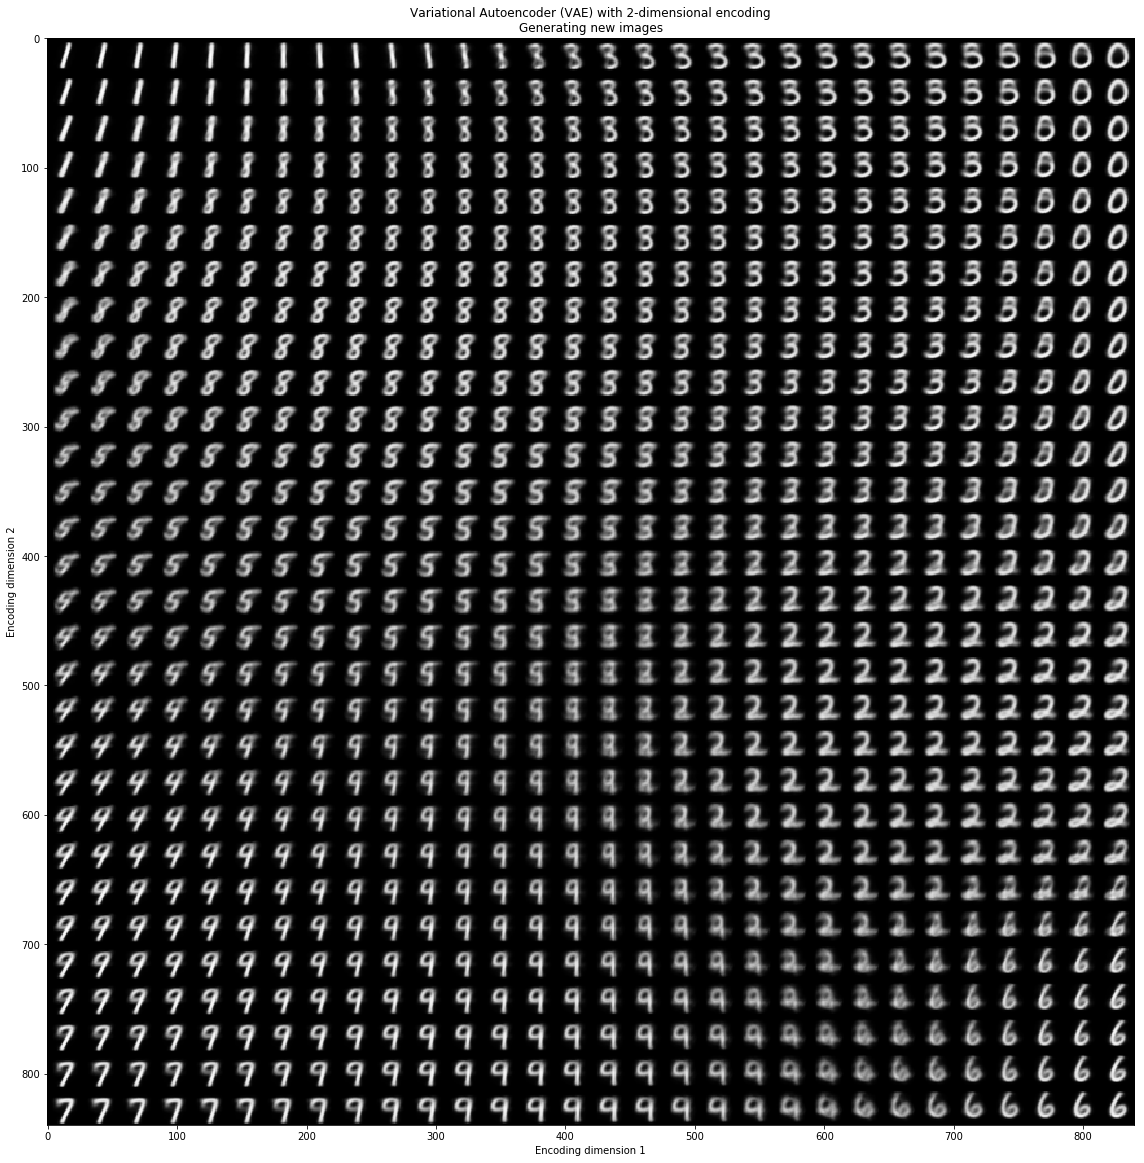

In [10]:
encoding_dim = 2

variational_autoencoder = VariationalAutoencoder(n_feat=X_train.shape[1],
                                                 n_epoch=100,
                                                 batch_size=100,
                                                 encoder_layers=3,
                                                 decoder_layers=3,
                                                 n_hidden_units=1000,
                                                 encoding_dim=encoding_dim,
                                                 denoising=None)

print(variational_autoencoder.autoencoder.summary())

pipe_variational_autoencoder = Pipeline(steps=[("autoencoder", variational_autoencoder),
                                               ("scaler_classifier", scaler_classifier),
                                               ("classifier", logistic)])

pipe_variational_autoencoder = pipe_variational_autoencoder.fit(X_train, y_train)

auroc_variational_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                              pipe_variational_autoencoder.predict_proba(X_test), 
                                              average="weighted")

acc_variational_autoencoder = pipe_variational_autoencoder.score(X_test, y_test)

print("The AUROC score for the MNIST classification task with a variational autoencoder: %.6f%%." % (auroc_variational_autoencoder * 100))
print("The accuracy score for the MNIST classification task with a variational autoencoder: %.6f%%." % (acc_variational_autoencoder * 100))

if encoding_dim == 2:
    test_encoded_df = pd.DataFrame(pipe_variational_autoencoder.named_steps["autoencoder"].encoder.predict(X_test))
    test_encoded_df["Target"] = y_test
    test_encoded_df.columns.values[0:2] = ["Encoding_1", "Encoding_2"]

    scaler_plot = MinMaxScaler(feature_range=(0.25, 0.75))
    scaler_plot = scaler_plot.fit(test_encoded_df[["Encoding_1", "Encoding_2"]])
    test_encoded_df[["Encoding_1", "Encoding_2"]] = scaler_plot.transform(test_encoded_df[["Encoding_1", "Encoding_2"]])

    cluster_plot = ggplot(test_encoded_df) + \
    geom_point(aes(x="Encoding_1", 
                   y="Encoding_2", 
                   fill="factor(Target)"),
               size=1,
               color = "black") + \
    xlab("Encoding dimension 1") + \
    ylab("Encoding dimension 2") + \
    ggtitle("Variational autoencoder with 2-dimensional encoding") + \
    theme_matplotlib()
    print(cluster_plot)

    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = pipe_variational_autoencoder.named_steps["autoencoder"].generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(20, 20))
    plt.imshow(figure, cmap="Greys_r")
    plt.title("Variational Autoencoder (VAE) with 2-dimensional encoding\nGenerating new images")
    plt.xlabel("Encoding dimension 1")
    plt.ylabel("Encoding dimension 2")
    plt.savefig(fname="VAE_Generated_Images.png")
    plt.show()

## MNIST: 2 Dimensional Convolutional Autoencoders

---

For 2 dimensional convolution filters the idea is similar as for the 1 dimensional convolution filters. We will stick to our previously mentioned banking example to illustrate this point.

$$
\begin{align*}
x = 
\begin{array}
{l}
\text{Period 1} \\ \text{Period 2} \\ \text{Period 3} \\ \text{Period 4} \\ \text{Period 5}
\end{array}
    \left[
    \begin{array}
    {ccc}
    \$0 & \$0 & \$0 \\
    \$0 & \$200 & \$0 \\
    \$100 & \$0 & \$0 \\
    \$0 & \$0 & \$300 \\
    \$0 & \$0 & \$0
    \end{array}
    \right]
\end{align*}
$$

In the 2 dimensional tensor of raw transactions data now we have 5 historical time periods, i.e., the rows, and 3 different transaction types, i.e., the columns. We will use a kernel, $\alpha \in \mathbb{R}^{2\times3}$, to extract useful features from the raw data. The choice of such a kernel means that we are interested in finding a feature map across all 3 transaction types and 2 historical time periods. We will use a stride length of 1 and a valid convolution to extract features over different patches of the raw data. The following will illustrate this point where $x_{\text{patch}} \subset x$:

$$
\begin{align*}
\alpha &=
    \left[
    \begin{array}
    {ccc}
    \alpha_{1,1} & \alpha_{1,2} & \alpha_{1,3} \\
    \alpha_{2,1} & \alpha_{2,2} & \alpha_{2,3}
    \end{array}
    \right] \\
x_{\text{patch}} &= 
    \left[
    \begin{array}
    {ccc}
    \$0 & \$0 & \$0 \\
    \$0 & \$200 & \$0
    \end{array}
    \right] \\
\mathbf{C}(x=x_{\text{patch}}|\alpha) &= x * \alpha \\
&= \sum_{t=1}^{2} \sum_{k=1}^{3} x_{t,k} \alpha_{t,k}
\end{align*}
$$

The principles and ideas apply to 2 dimensional convolution filters as they do for their 1 dimensional counterparts there we will not repeat them here.

### Results

---

* The AUROC score for the MNIST classification task with a 2 dimensional convolutional autoencoder: 99.987741%.
* The accuracy score for the MNIST classification task with a 2 dimensional convolutional autoencoder: 98.860000%.

In [ ]:
convolutional2D_autoencoder = Convolutional2DAutoencoder(input_shape=(int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5)), 1),
                                                         n_epoch=5,
                                                         batch_size=100,
                                                         encoder_layers=3,
                                                         decoder_layers=3,
                                                         filters=100,
                                                         kernel_size=(8, 8),
                                                         strides=(1, 1),
                                                         pool_size=(4, 4),
                                                         denoising=None)

print(convolutional2D_autoencoder.autoencoder.summary())

pipe_convolutional2D_autoencoder = Pipeline(steps=[("autoencoder", convolutional2D_autoencoder),
                                                   ("scaler_classifier", scaler_classifier),
                                                   ("classifier", logistic)])

pipe_convolutional2D_autoencoder = pipe_convolutional2D_autoencoder.fit(np.reshape(X_train, [X_train.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5)), 1]),
                                                                        y_train)

auroc_convolutional2D_autoencoder = roc_auc_score(lb.transform(y_test.reshape(y_test.shape[0], 1)), 
                                                  pipe_convolutional2D_autoencoder.predict_proba(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_train.shape[1], 0.5)), int(math.pow(X_train.shape[1], 0.5)), 1])),
                                                  average="weighted")

acc_convolutional2D_autoencoder = pipe_convolutional2D_autoencoder.score(np.reshape(X_test, [X_test.shape[0], int(math.pow(X_test.shape[1], 0.5)), int(math.pow(X_test.shape[1], 0.5)), 1]), y_test)

print("The AUROC score for the MNIST classification task with a 2 dimensional convolutional autoencoder: %.6f%%." % (auroc_convolutional2D_autoencoder * 100))
print("The accuracy score for the MNIST classification task with a 2 dimensional convolutional autoencoder: %.6f%%." % (acc_convolutional2D_autoencoder * 100))

## Insurance: No Autoencoders

---

We now proceed to run the insurance model without any handcrafted or deep learning based feature engineering.

### Results

---

* The AUROC score for the insurance classification task without autoencoders: 92.206261%.
* The accuracy score for the insurance classification task without autoencoders: 82.333333%.

In [ ]:
claim_risk = pd.read_csv(filepath_or_buffer="../R/data/claim_risk.csv")
claim_risk.drop(columns="policy.id", axis=1, inplace=True)
claim_risk = np.asarray(claim_risk).ravel()

transactions = pd.read_csv(filepath_or_buffer="../R/data/transactions.csv")
transactions.drop(columns="policy.id", axis=1, inplace=True)

n_policies = 1000
n_transaction_types = 3
n_time_periods = 4

transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods * n_transaction_types))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)

min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

pipe_base = Pipeline(steps=[("scaler_classifier", scaler_classifier),
                            ("classifier", logistic)])

pipe_base = pipe_base.fit(X_train, y_train)

auroc_base = roc_auc_score(y_true=y_test,
                           y_score=pipe_base.predict_proba(X_test)[:, 1], 
                           average="weighted")
    
acc_base = pipe_base.score(X_test, y_test)

print("The AUROC score for the insurance classification task without autoencoders: %.6f%%." % (auroc_base * 100))
print("The accuracy score for the insurance classification task without autoencoders: %.6f%%." % (acc_base * 100))

## Insurance: PCA

---

We now proceed to run the insurance model without any handcrafted or deep learning based feature engineering however with a PCA filter that picks the number of components that explain $99\%$ of the variation.

### Results

---

* The AUROC score for the insurance classification task with PCA: 91.128859%.
* The accuracy score for the insurance classification task with PCA: 82.000000%.

In [ ]:
pipe_pca = Pipeline(steps=[("PCA", PCA(n_components=0.99)),
                           ("scaler_classifier", scaler_classifier),
                           ("classifier", logistic)])

pipe_pca = pipe_pca.fit(X_train, y_train)

auroc_pca = roc_auc_score(y_true=y_test,
                          y_score=pipe_pca.predict_proba(X_test)[:, 1], 
                          average="weighted")
    
acc_pca = pipe_pca.score(X_test, y_test)

print("The AUROC score for the insurance classification task with PCA: %.6f%%." % (auroc_pca * 100))
print("The accuracy score for the insurance classification task with PCA: %.6f%%." % (acc_pca * 100))

## Insurance: Handcrafted Features

---

In this case we have created some handcrafted features which we believe provide a useful representation of the raw data for the insurance model.

### Results

---

* The AUROC score for the insurance classification task with handcrafted features: 93.610635%.
* The accuracy score for the insurance classification task with handcrafted features: 85.000000%.

In [ ]:
claim_risk = pd.read_csv(filepath_or_buffer="../R/data/claim_risk.csv")
claim_risk.drop(columns="policy.id", axis=1, inplace=True)
claim_risk = np.asarray(claim_risk).ravel()

handcrafted_features = pd.read_csv(filepath_or_buffer="../R/data/handcrafted_features.csv")
handcrafted_features = np.asarray(handcrafted_features)

n_policies = 1000
n_feat = 12

X_train, X_test, y_train, y_test = train_test_split(handcrafted_features, claim_risk, test_size=0.3, random_state=666)

min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

pipe_hcfe = Pipeline(steps=[("scaler_classifier", scaler_classifier),
                            ("classifier", logistic)])

pipe_hcfe = pipe_hcfe.fit(X_train, y_train)

auroc_hcfe = roc_auc_score(y_true=y_test,
                           y_score=pipe_hcfe.predict_proba(X_test)[:, 1], 
                           average="weighted")
    
acc_hcfe = pipe_hcfe.score(X_test, y_test)

print("The AUROC score for the insurance classification task with handcrafted features: %.6f%%." % (auroc_hcfe * 100))
print("The accuracy score for the insurance classification task with handcrafted features: %.6f%%." % (acc_hcfe * 100))

## Insurance: Handcrafted Features and PCA

---

In this case we have created some handcrafted features which we believe provide a useful representation of the raw data for the insurance model. We also use a PCA filter.

### Results

---

* The AUROC score for the insurance classification task with handcrafted features and PCA: 93.160377%.
* The accuracy score for the insurance classification task with handcrafted features and PCA: 83.333333%.

In [ ]:
pipe_hcfe_pca = Pipeline(steps=[("PCA", PCA(n_components=0.99)),
                                ("scaler_classifier", scaler_classifier),
                                ("classifier", logistic)])
    
pipe_hcfe_pca = pipe_hcfe_pca.fit(X_train, y_train)

auroc_hcfe_pca = roc_auc_score(y_true=y_test,
                               y_score=pipe_hcfe_pca.predict_proba(X_test)[:, 1], 
                               average="weighted")
    
acc_hcfe_pca = pipe_hcfe_pca.score(X_test, y_test)

print("The AUROC score for the insurance classification task with handcrafted features and PCA: %.6f%%." % (auroc_hcfe_pca * 100))
print("The accuracy score for the insurance classification task with handcrafted features and PCA: %.6f%%." % (acc_hcfe_pca * 100))

## Insurance: Vanilla Autoencoders

---

In this case we use vanilla autoencoders to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with an autoencoder: 93.932247%.
* The accuracy score for the insurance classification task with an autoencoder: 85.000000%.

In [ ]:
autoencoder = VanillaAutoencoder(n_feat=X_train.shape[1],
                                 n_epoch=100,
                                 batch_size=50,
                                 encoder_layers=3,
                                 decoder_layers=3,
                                 n_hidden_units=100,
                                 encoding_dim=50,
                                 denoising=None)

print(autoencoder.autoencoder.summary())

pipe_autoencoder = Pipeline(steps=[("autoencoder", autoencoder),
                                   ("scaler_classifier", scaler_classifier),
                                   ("classifier", logistic)])

pipe_autoencoder = pipe_autoencoder.fit(X_train, y_train)

auroc_autoencoder = roc_auc_score(y_true=y_test,
                                  y_score=pipe_autoencoder.predict_proba(X_test)[:, 1], 
                                  average="weighted")
    
acc_autoencoder = pipe_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with an autoencoder: %.6f%%." % (auroc_autoencoder * 100))
print("The accuracy score for the insurance classification task with an autoencoder: %.6f%%." % (acc_autoencoder * 100))

## Insurance: Denoising Autoencoders

---

In this case we use denoising autoencoders to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with a denoising autoencoder: 93.712479%.
* The accuracy score for the insurance classification task with a denoising autoencoder: 85.333333%.

In [ ]:
noise = 0.10 * np.reshape(np.random.uniform(low=0.0, 
                                            high=1.0, 
                                            size=X_train.shape[0] * X_train.shape[1]), 
                          [X_train.shape[0], X_train.shape[1]])

denoising_autoencoder = VanillaAutoencoder(n_feat=X_train.shape[1],
                                           n_epoch=100,
                                           batch_size=50,
                                           encoder_layers=3,
                                           decoder_layers=3,
                                           n_hidden_units=100,
                                           encoding_dim=50,
                                           denoising=noise)

print(denoising_autoencoder.autoencoder.summary())

pipe_denoising_autoencoder = Pipeline(steps=[("autoencoder", denoising_autoencoder),
                                             ("scaler_classifier", scaler_classifier),
                                             ("classifier", logistic)])

pipe_denoising_autoencoder = pipe_denoising_autoencoder.fit(X_train, y_train)

auroc_denoising_autoencoder = roc_auc_score(y_true=y_test,
                                            y_score=pipe_denoising_autoencoder.predict_proba(X_test)[:, 1], 
                                            average="weighted")
    
acc_denoising_autoencoder = pipe_denoising_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with a denoising autoencoder: %.6f%%." % (auroc_denoising_autoencoder * 100))
print("The accuracy score for the insurance classification task with a denoising autoencoder: %.6f%%." % (acc_denoising_autoencoder * 100))

## Insurance: Sequence to Sequence Autoencoders

---

In this case we use sequence to sequence autoencoders, taking into account the time series nature, i.e., sequential nature, of the raw transactions data, to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with a sequence to sequence autoencoder: 91.418310%.
* The accuracy score for the insurance classification task with a sequence to sequence autoencoder: 84.000000%.

In [ ]:
transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods, n_transaction_types))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)

min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

seq2seq_autoencoder = Seq2SeqAutoencoder(input_shape=(X_train.shape[1], X_train.shape[2]),
                                         n_epoch=100,
                                         batch_size=50,
                                         encoder_layers=3,
                                         decoder_layers=3,
                                         n_hidden_units=50,
                                         encoding_dim=50,
                                         stateful=False,
                                         denoising=None)

print(seq2seq_autoencoder.autoencoder.summary())

pipe_seq2seq_autoencoder = Pipeline(steps=[("autoencoder", seq2seq_autoencoder),
                                           ("scaler_classifier", scaler_classifier),
                                           ("classifier", logistic)])

pipe_seq2seq_autoencoder = pipe_seq2seq_autoencoder.fit(X_train, y_train)

auroc_seq2seq_autoencoder = roc_auc_score(y_test, 
                                          pipe_seq2seq_autoencoder.predict_proba(X_test)[:, 1],
                                          average="weighted")

acc_seq2seq_autoencoder = pipe_seq2seq_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with a sequence to sequence autoencoder: %.6f%%." % (auroc_seq2seq_autoencoder * 100))
print("The accuracy score for the insurance classification task with a sequence to sequence autoencoder: %.6f%%." % (acc_seq2seq_autoencoder * 100))

## Insurance: 1 Dimensional Convolutional Autoencoders

---

In this case we use 1 dimensional convolutional autoencoders to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with a 1 dimensional convolutional autoencoder: 91.509434%.
* The accuracy score for the insurance classification task with a 1 dimensional convolutional autoencoder: 84.666667%.

In [ ]:
transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods, n_transaction_types))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)
min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

convolutional_autoencoder = ConvolutionalAutoencoder(input_shape=(X_train.shape[1], X_train.shape[2]),
                                                     n_epoch=100,
                                                     batch_size=50,
                                                     encoder_layers=3,
                                                     decoder_layers=3,
                                                     filters=50,
                                                     kernel_size=2,
                                                     strides=1,
                                                     pool_size=2,
                                                     denoising=None)

print(convolutional_autoencoder.autoencoder.summary())

pipe_convolutional_autoencoder = Pipeline(steps=[("autoencoder", convolutional_autoencoder),
                                                 ("scaler_classifier", scaler_classifier),
                                                 ("classifier", logistic)])

pipe_convolutional_autoencoder = pipe_convolutional_autoencoder.fit(X_train, y_train)

auroc_convolutional_autoencoder = roc_auc_score(y_test, 
                                                pipe_convolutional_autoencoder.predict_proba(X_test)[:, 1],
                                                average="weighted")

acc_convolutional_autoencoder = pipe_convolutional_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with a 1 dimensional convolutional autoencoder: %.6f%%." % (auroc_convolutional_autoencoder * 100))
print("The accuracy score for the insurance classification task with a 1 dimensional convolutional autoencoder: %.6f%%." % (acc_convolutional_autoencoder * 100))

## Insurance: 2 Dimensional Convolutional Autoencoders

---

In this case we use 2 dimensional convolutional autoencoders to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with a 2 dimensional convolutional autoencoder: 92.645798%.
* The accuracy score for the insurance classification task with a 2 dimensional convolutional autoencoder: 86.000000%.

In [ ]:
transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods, n_transaction_types, 1))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)
min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

convolutional2D_autoencoder = Convolutional2DAutoencoder(input_shape=(X_train.shape[1], X_train.shape[2], 1),
                                                         n_epoch=100,
                                                         batch_size=50,
                                                         encoder_layers=3,
                                                         decoder_layers=3,
                                                         filters=50,
                                                         kernel_size=(2, 3),
                                                         strides=(1, 1),
                                                         pool_size=(2, 1),
                                                         denoising=None)

print(convolutional2D_autoencoder.autoencoder.summary())

pipe_convolutional2D_autoencoder = Pipeline(steps=[("autoencoder", convolutional2D_autoencoder),
                                                   ("scaler_classifier", scaler_classifier),
                                                   ("classifier", logistic)])

pipe_convolutional2D_autoencoder = pipe_convolutional2D_autoencoder.fit(X_train, y_train)

auroc_convolutional2D_autoencoder = roc_auc_score(y_test, 
                                                  pipe_convolutional2D_autoencoder.predict_proba(X_test)[:, 1],
                                                  average="weighted")

acc_convolutional2D_autoencoder = pipe_convolutional2D_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with a 2 dimensional convolutional autoencoder: %.6f%%." % (auroc_convolutional2D_autoencoder * 100))
print("The accuracy score for the insurance classification task with a 2 dimensional convolutional autoencoder: %.6f%%." % (acc_convolutional2D_autoencoder * 100))

## Insurance: Variational Autoencoders

---

In this case we use variational autoencoders to learn a good representation of the raw data such that we can obtain an uplift, primarily in terms of AUROC, for the supervised learning task.

### Results

---

* The AUROC score for the insurance classification task with a variational autoencoder: 90.871569%.
* The accuracy score for the insurance classification task with a variational autoencoder: 83.666667%.

In [ ]:
transactions = np.reshape(np.asarray(transactions), (n_policies, n_time_periods * n_transaction_types))

X_train, X_test, y_train, y_test = train_test_split(transactions, claim_risk, test_size=0.3, random_state=666)

min_X_train = np.apply_along_axis(func1d=np.min, axis=0, arr=X_train)
max_X_train = np.apply_along_axis(func1d=np.max, axis=0, arr=X_train) 
range_X_train = max_X_train - min_X_train + sys.float_info.epsilon
X_train = (X_train - min_X_train) / range_X_train
X_test = (X_test - min_X_train) / range_X_train

variational_autoencoder = VariationalAutoencoder(n_feat=X_train.shape[1],
                                                 n_epoch=100,
                                                 batch_size=50,
                                                 encoder_layers=3,
                                                 decoder_layers=3,
                                                 n_hidden_units=100,
                                                 encoding_dim=50,
                                                 denoising=None)

print(variational_autoencoder.autoencoder.summary())

pipe_variational_autoencoder = Pipeline(steps=[("autoencoder", variational_autoencoder),
                                               ("scaler_classifier", scaler_classifier),
                                               ("classifier", logistic)])

pipe_variational_autoencoder = pipe_variational_autoencoder.fit(X_train, y_train)

auroc_variational_autoencoder = roc_auc_score(y_true=y_test,
                                              y_score=pipe_variational_autoencoder.predict_proba(X_test)[:, 1], 
                                              average="weighted")
    
acc_variational_autoencoder = pipe_variational_autoencoder.score(X_test, y_test)

print("The AUROC score for the insurance classification task with a variational autoencoder: %.6f%%." % (auroc_variational_autoencoder * 100))
print("The accuracy score for the insurance classification task with a variational autoencoder: %.6f%%." % (acc_variational_autoencoder * 100))

## References

---

1. Goodfellow, I., Bengio, Y. and Courville A. (2016). Deep Learning (MIT Press).
2. Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & Tensorflow (O'Reilly).
3. http://scikit-learn.org/stable/#
4. https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
5. https://stackoverflow.com/questions/42177658/how-to-switch-backend-with-keras-from-tensorflow-to-theano
6. https://blog.keras.io/building-autoencoders-in-keras.html
7. https://keras.io
8. https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf
9. http://deeplearning.net/tutorial/lstm.html
10. Kingma, D. P., and Welling M. (2014). Auto-Encoding Variational Bayes (https://arxiv.org/abs/1312.6114). 